In [1]:
from pathlib import Path
import itertools
from functools import reduce
import os

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm


from lobib import DataLoader

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

def save_fig(name):
    plt.savefig(f"../figures/fit/{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../figures/fit/{name}.png", bbox_inches='tight', dpi=150)


HOURS_PER_DAY = 5.5
DAY_NS = int(5.5 * 3600 * 1e9)  # 5.5 hours in nanoseconds
HOUR_NS = int(3600 * 1e9)
TICK_TO_USD = 0.01

In [2]:
loader = DataLoader()

def preprocess(df: pl.LazyFrame) -> pl.LazyFrame:
    """Preprocess raw order book data for estimation."""
    # Filter valid events (removed spread <= 4 filter)
    df = df.filter(
        pl.col("event_side")
        .replace({"A": 1, "B": -1})
        .cast(int)
        .mul(pl.col("event_queue_nbr"))
        >= 0
    )

    # Filter rows with best_bid_nbr and best_ask_nbr in expected range
    df = df.filter(
        pl.col("best_bid_nbr").is_between(-10, -1)
        & pl.col("best_ask_nbr").is_between(1, 10)
    )
    df = df.with_columns(pl.col("event").replace({"Trd_All": "Trd"}))
    df = df.with_columns(pl.col("P_1").add(pl.col("P_-1")).truediv(2).alias("mid"))

    return df
    
def load_data(ticker: str) -> pl.LazyFrame:
    """Load raw order book data for a ticker."""
    info = loader.ticker_info(ticker)
    df = loader.load(
        ticker,
        start_date=info["date"].min(),
        end_date=info["date"].max(),
        schema="qr",
    ).sort(["date", "ts_event"])
    return preprocess(df)

def compute_eta(df: pl.LazyFrame) -> pl.DataFrame:
  """Compute eta per trading day."""
  return (
      df
      .with_columns(
          pl.col("mid").diff().over("date").alias("mid_diff")
      )
      .with_columns(
          pl.col("mid_diff").sign().alias("sign"),
          pl.col("mid_diff").sign().shift(1).over("date").alias("prev_sign")
      )
      .filter(pl.col("mid_diff").ne(0) & pl.col("prev_sign").is_not_null() & pl.col("prev_sign").ne(0))
      .with_columns(
          (pl.col("sign") == pl.col("prev_sign")).alias("is_continuation"),
          (pl.col("sign") != pl.col("prev_sign")).alias("is_alternation")
      )
      .group_by("date")
      .agg(
          pl.col("is_continuation").sum().alias("n_continuations"),
          pl.col("is_alternation").sum().alias("n_alternations")
      )
      .with_columns(
          (pl.col("n_continuations") / (2 * pl.col("n_alternations"))).alias("eta")
      ).collect(engine="streaming")
  )

def compute_volatility(df: pl.LazyFrame) -> pl.DataFrame:
    return (
      df
      .with_columns((pl.col("mid") * TICK_TO_USD).diff().over("date").alias("mid_diff"))
      .filter(pl.col("mid_diff").is_not_null())
      .group_by("date")
      .agg((pl.col("mid_diff") ** 2).sum().alias("realized_var"))
      .with_columns(
          (pl.col("realized_var") / HOURS_PER_DAY).sqrt().alias("volatility_per_hour")
      )
      .collect(engine="streaming")
    )

In [3]:
def plot_vol_eta(ticker: str) -> None:
    df = load_data(ticker)
    eta = compute_eta(df)
    vol = compute_volatility(df)
    
    df_ = pl.scan_parquet(f"../data/results/{ticker}/result.parquet").filter(~pl.col("rejected"))
    df_ = df_.with_columns(
      (pl.col("ts_event") // DAY_NS).alias("date")
    )
    vol_ = compute_volatility(df_)
    eta_ = compute_eta(df_)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    
    # Volatility
    ax1.hist(vol["volatility_per_hour"], bins=30, label="Empirical", density=True, alpha=0.7, color="tab:blue")
    ax1.set_ylabel("Empirical density")
    ax1_twin = ax1.twinx()
    ax1_twin.hist(vol_["volatility_per_hour"], bins=10, label="QR", density=True, alpha=0.7, color="tab:orange")
    ax1_twin.set_ylabel("QR density")
    ax1.set_xlabel(r"Volatility (USD / $\sqrt{\mathrm{hour}}$)")
    ax1.set_title(r"Realized Volatility: $\sigma = \sqrt{\sum_i (\Delta P_i)^2 \,/\, T}$")
    ax1.legend(loc="upper left")
    ax1_twin.legend(loc="upper right")
    
    # Eta
    ax2.hist(eta["eta"], bins=30, label="Empirical", density=True, alpha=0.7, color="tab:blue")
    ax2.set_ylabel("Empirical density")
    ax2_twin = ax2.twinx()
    ax2_twin.hist(eta_["eta"], bins=10, label="QR", density=True, alpha=0.7, color="tab:orange")
    ax2_twin.set_ylabel("QR density")
    ax2.set_xlabel(r"$\eta$")
    ax2.set_title(r"$\eta = N_{\mathrm{cont}} \,/\, 2 N_{\mathrm{alt}}$")
    ax2.legend(loc="upper left")
    ax2_twin.legend(loc="upper right")
    
    plt.tight_layout()
    plt.suptitle(f"Ticker: {ticker}")
    plt.show()

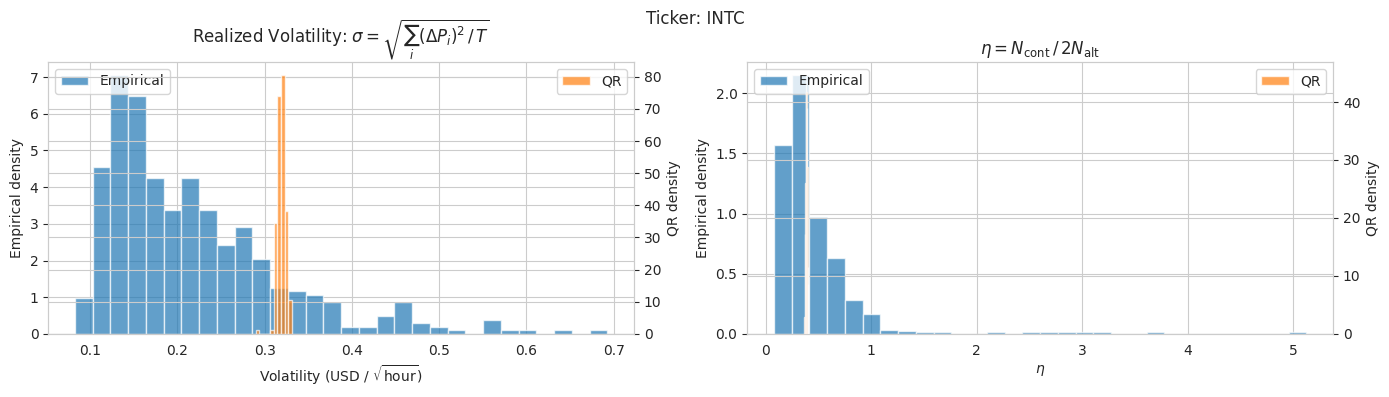

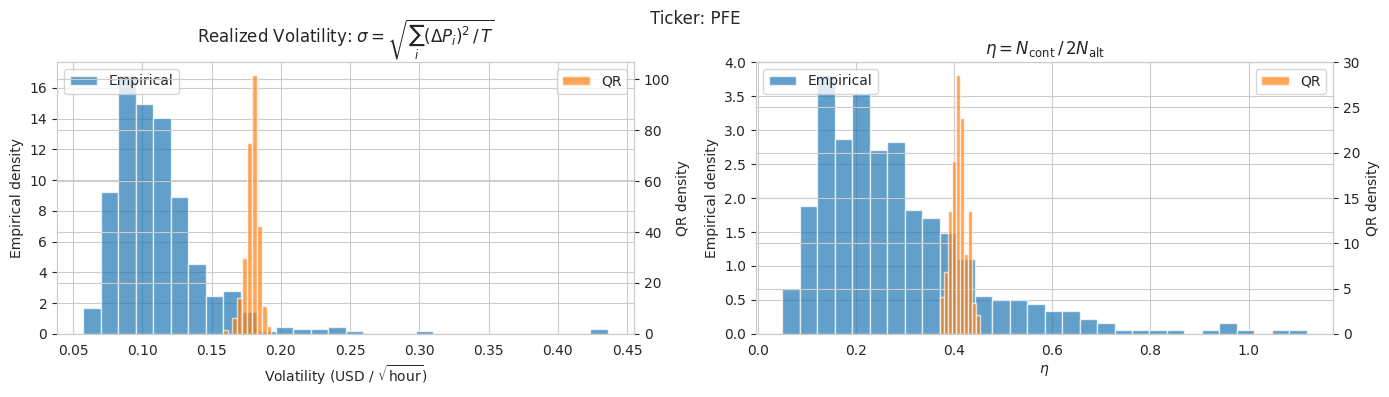

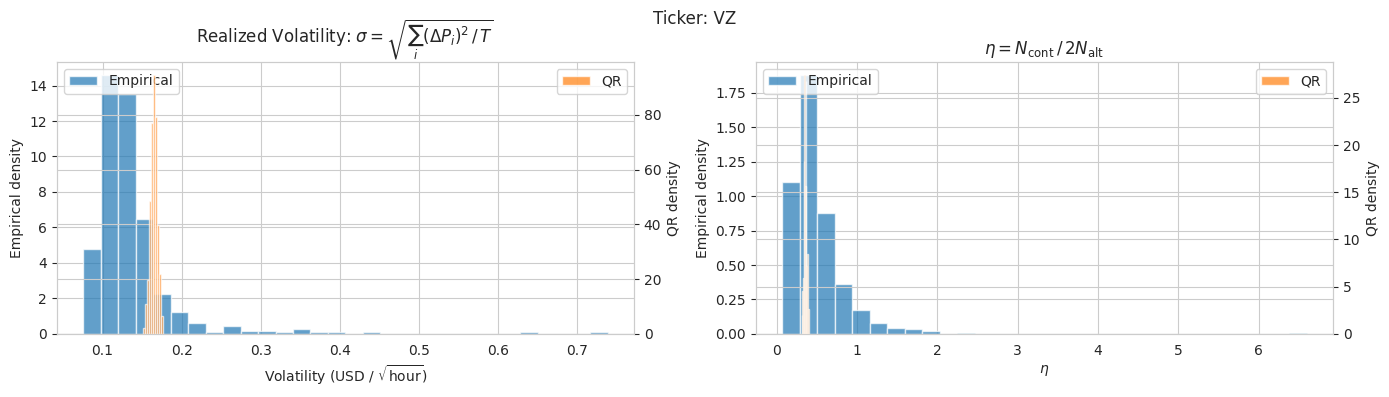

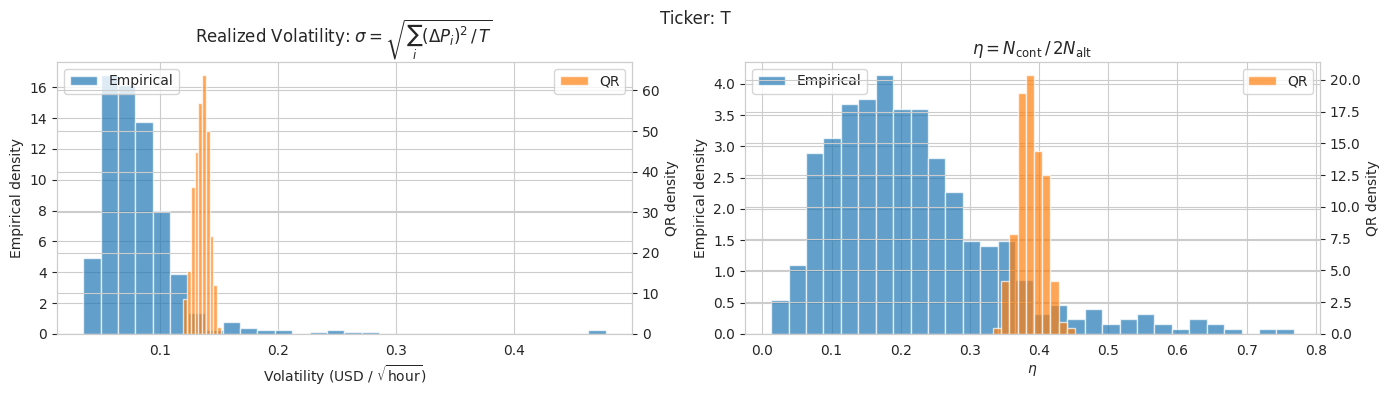

In [52]:
for ticker in ["INTC", "PFE", "VZ", "T"]:
    plot_vol_eta(ticker)

In [5]:
ticker = "PFE"
df = pl.read_parquet(f"../data/results/{ticker}/result.parquet").filter(~pl.col("rejected"))

In [7]:
df["event"].value_counts()

event,count
str,u32
"""Cancel""",11119129
"""CreateBid""",238127
"""CreateAsk""",237356
"""Trade""",504872
"""Add""",10646600
